# Step 2: Analytical tube-transducer model

Another method for estimating the transfer function (TF) of a remote microphone probe (RMP) is through modelling the fluid-dynamics that affect the response of the probe, i.e. viscosity and the reflection of pressure waves on geometrical- or fluid-property discontinuities.

Many analytical models exist to estimate the TF of line-cavity systems, based on the simplified and linearised Navier-Stokes + Energy equations. A well known model is that of Bergh & Tijdeman [1965]. In this notebook the model of Whitmore [2006] is presented, as it allows for branching tube-cavity systems. Both models are implemented in *Source.BerghTijdemanWhitmoreModels.py*.

These models rely on modelling the pneumatic system as several **tube-cavity or tube-transducer** elements linked together in series or parallel. Each tube-cavity has a specific tube length, tube radius, and (transducer) cavity volume. Each element has a constant cross-section tube. Discontinuities in tube cross-section etc. are modelled by connecting several tube-cavity elements, with different properties, together.

<img alt="Tube-cavity elements connected in series as used by the Bergh & Tijdeman model and many other similar analytical models for the frequency response of pneumatic systems." src="./Media/TubeTransducerConcept.png" title="Tube-cavity/tube-transducer elements in series." width="800"/>

In [19]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import Source.BerghTijdemanWhitmoreModels as tt_m  # Analytical models.
from Source.PlottingFunctions import plot_transfer_function_df  # Plotting of TFs.

The models use several fluid-dynamical variables defined below.

In [20]:
GAMMA, PR, C0, NU = 1.4, 0.7, 340.26, 1.46E-5  # Conditions used in model.

The frequencies on which the model estimates the TF are defined in the following way. The points are distributed logarithmically because the x-axis will be plotted logarithmically anyway.

In [21]:
# Minimum frequency, maximum frequency, number of samples between min and max.
F_MIN, F_MAX, N_F_SAMPLES = 1E2, 2E4, 1001
# Frequency array in Hz.
f_arr = np.logspace(np.log10(F_MIN), np.log10(F_MAX),N_F_SAMPLES)
# Frequency array in rad/s.
w_arr = 2*np.pi*f_arr

## Pinhole example

To start with the full model equations for a very simple pinhole RMP are presented.
This is the simplest geometry as it can be represented by a single tube-cavity element.

The dimensional geometrical parameters of the probe are length, radius, and volume (in SI units).

In [22]:
LENGTH_PINHOLE = 2E-3  # m
RADIUS_PINHOLE = 0.25E-3  # m
CAVITY_VOLUME_PINHOLE = 20E-9  # m^3

The model of Whitmore (also that of Bergh & Tijdeman) features a lot of recurring combinations of the above geometrical and flow properties. These are defined as the non-dimensional parameters of the model.
These non-dimensional parameters lump together all parameters that affect the TF of the model in a similar manner, for example with the Helmholtz equation for cavity resonance the resonant frequency is dependent on the cavity-to-tube volume ratio. Therefore, the same resonant frequency can be achieved with various combinations of $L$, $R$, and $V_v$. This would not be optimal for the proposed fitting of the model TF on calibration data, so the models in *Source.BerghTijdemanWhitmoreModels.py* use non-dimensionalised input parameters.

$$ f_{r, \ cavity} = \frac{c}{2 \pi L} \sqrt{\frac{V_t}{V_v}} $$

The non-dimensional geometrical parameters are: the reduced frequency $k_{L}$, the shear wave number $\alpha$, and the cavity-to-tube volume ratio $V_v/V_t$.
The reduced frequency resembles the equation for tube resonant frequencies. So clearly, it impacts the tube resonance.
The shear wave number contains the tube radius, and kinematic viscosity $\nu$. It represents the regime of the flow in the tube (much like a Reynolds number), so also the profile of the velocity of the pressure waves. This parameter affects the impact of viscosity on the TF.
Lastly, the volume ratio can also be found in the Helmholtz equation. So clearly, this parameter affects cavity resonance.

In [23]:
# Wave-number after multiplying the wave-number constant with the angular frequency array.
k_l_j = LENGTH_PINHOLE/C0 * w_arr
# Shear wave number after multiplying the Shear wave number constant with the angular frequency array.
alpha_j = 1j**1.5 * RADIUS_PINHOLE * np.sqrt(w_arr/NU)
# Cavity-volume to tube-volume ratio.
vv_vt_j = CAVITY_VOLUME_PINHOLE / (LENGTH_PINHOLE * np.pi*RADIUS_PINHOLE**2)

These non-dimensional input parameters then affect various other model parameters and the physics that these parameters represent.
As these models assume polytropic flow, the polytropic constant $n_j$ needs to be estimated. The extremes of this parameter are $n_j=1$ for isothermal behaviour, and $n_j=\gamma=1.4$ for isentropic behaviour. As can be seen, this is also a frequency-dependent parameter.
The wave propagation factor reflects the attenuation and phase delay of the pressure waves per unit length of the tube, this parameter is the same as can be found in the exponents of the solution to the wave equation: $$ p'(x, \omega) = A(\omega) \cdot \exp[(\phi_j L_j) x] + B(\omega) \cdot \exp[-(\phi_j L_j) x] $$

In [24]:
n_j = 1/(1 + (GAMMA-1)/GAMMA * tt_m.j_2_j_0(alpha_j * PR**0.5))  # Polytropic constant.
phi_j = w_arr/C0 * np.sqrt(GAMMA/(n_j * tt_m.j_2_j_0(alpha_j)))  # Wave propagation factor.
# Wave propagation factor * tube length.
phi_l_j = phi_j * LENGTH_PINHOLE  # = k_l_j * np.sqrt(GAMMA/(n_j * tt_m.j_2_j_0(alpha_j)))

Note the reappearance of reduced-frequency in the wave propagation factor times tube-length. $$ \phi_j L_j = \frac{\omega L_j}{c_j} \sqrt{\frac{J_0(\alpha_j)}{J_2(\alpha_j)} \frac{\gamma}{n_j}} = k_{L, j} \sqrt{\frac{J_0(\alpha_j)}{J_2(\alpha_j)} \frac{\gamma}{n_j}} = k_{L, j} \Gamma_{p, j} $$

Here $\Gamma_{p, j}$ is the notation of wave propagation factor employed by Whitmore, and $\phi_j$ is the notation of Bergh & Tijdeman.

A final intermediary parameter *for the Whitmore model* is the **effective** volume ($V_e$) to tube volume ratio. This parameter is meant to account for the impact of other tube-cavity elements that are attached downstream to the current cavity of this tube-cavity element. It is a complex-valued array (a complex number for each frequency).

$$ \left(\frac{V_e}{V_t}\right)_{j} = \left(\frac{V_v}{V_t}\right)_{j} \left[ 1 + \sum_{i=1}^N \Phi_{i, j} \right] $$

The effective volume ratio is a function of the real-valued cavity volume ratio and the sum of the complex impedance $\Phi_{i, j}$ of all elements ($i$=1, 2, ...) connected to the cavity of element $j$. For serial geometries, only a single element is connected to the cavity volume. For branching geometries, multiple elements are connected to the cavity volume. In case no further elements are connected to the current element $\sum \Phi_{i, j} = 0$, and $V_e = V_v$ (as is the case for this simple pinhole geometry).

In [25]:
ve_vt_j = vv_vt_j  # Effective volume over tube volume, Ve/Vt [-].

From the wave propagation factor and the effective-to-tube volume ratio, the transfer function of element $j$ can be modelled. This TF accounts only for the change in pressure fluctuations between the tube inlet of element $j$ to the end of the cavity of element $j$. This TF can be computed for the various coupled tube-cavity elements and multiplied together, resulting in the full TF from point a (e.g. inlet of RMP) to point b (e.g. microphone of RMP).

In [26]:
# Pressure ratio of cavity w.r.t. inlet of tube = p_j/p_{j-1}.
p_j__p_j_1 = 1 / (np.cosh(phi_l_j) + ve_vt_j*phi_l_j*np.sinh(phi_l_j))

As comparison, the Helmholtz equation derived cavity resonance is also shown in the figure.

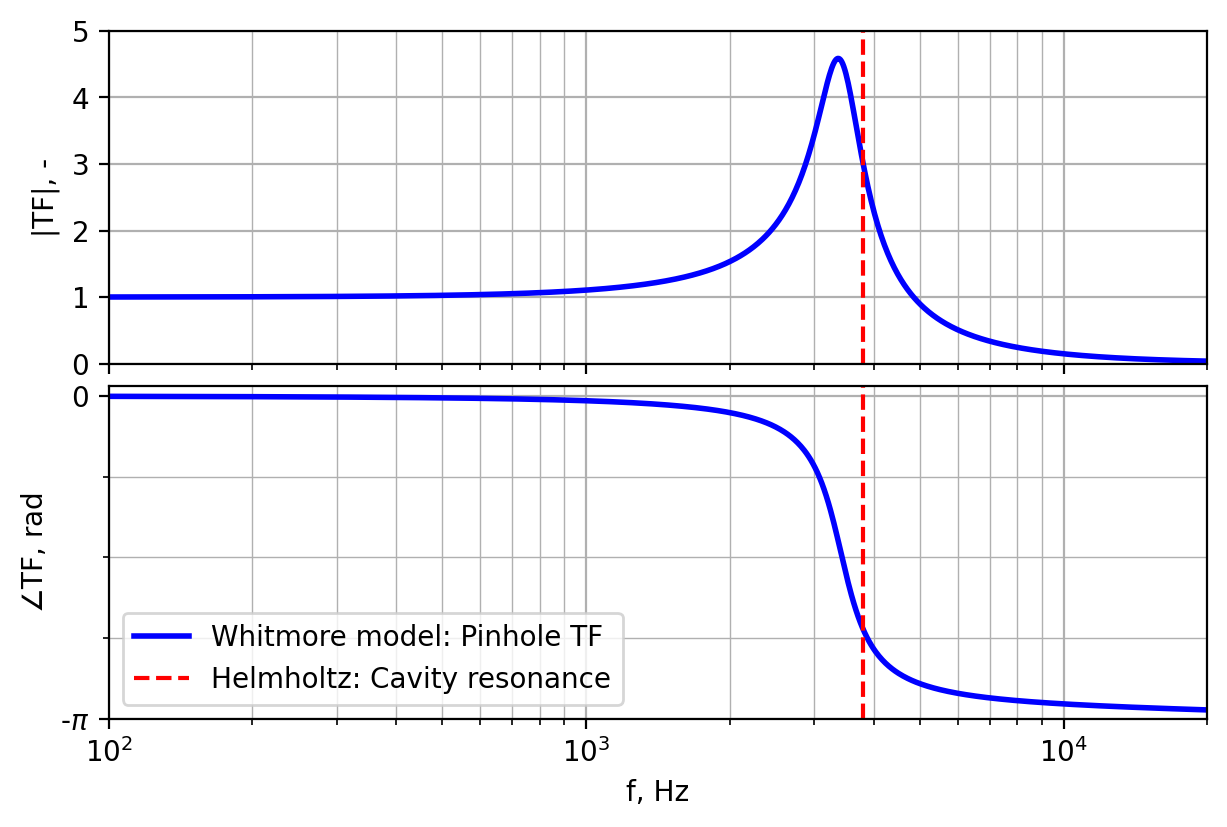

In [27]:
# Helmholtz equation for cavity resonance.
f_r_cavity = C0 / (2*np.pi*LENGTH_PINHOLE) * np.sqrt(1/vv_vt_j)
# Plotting.
df_pr_j = pd.DataFrame(p_j__p_j_1, columns=['Whitmore model: Pinhole TF'], index=f_arr)
df_pr_j.index.name = 'f, Hz'
fig_pin, ax_pin = plot_transfer_function_df(
    df=df_pr_j, fig_dim=(6, 4), x_lim=(F_MIN, F_MAX), y_lim_amp=(0, 5), y_lim_phase=(-np.pi, 0.1),
    color='b', linewidth=2, minor_phase=0.25)
[ax_pin_i.axvline(f_r_cavity, color='r', linestyle='--', label='Helmholtz: Cavity resonance') for ax_pin_i in ax_pin];
ax_pin[1].legend(loc='lower left')
fig_pin.tight_layout(pad=0.1)

A single resonant frequency can be seen in this case. This is confirmed by the Helmholtz cavity resonant frequency being relatively close. The difference in estimation of the resonant frequency can be due to end-effects of the tube, and/or a better modelling of the viscous effects on both resonant amplitude (and the accompanying phase shift slope) and the resonant frequency (which tends to be pulled to the lower frequencies). In case a longer tube-length is chosen, the cavity resonant frequency will change with $V_v/V_t$, but additional resonant frequencies might show up. These are linked to the line resonance (and its modes).

Feel free to play around with the above parameters to see their impact on the TF.

## Serial tube-transducer geometries

As mentioned, more complex microphone probe geometries can be built from multiple tube-transducer elements. The first example is two elements connected in series, each with a different radius and volume.

In [28]:
# For both elements: Tube length [m], tube radius [m], cavity volume [m^3].
LRV_ELEMENT_0 = (2E-3, 0.25E-3, 10E-9)  # Element 0 (closest to inlet of probe).
LRV_ELEMENT_1 = (2E-3, 0.50E-3, 20E-9)  # Element 1 (attached to the cavity of element 0, most downstream).

Once again, these dimensional geometrical parameters can be non-dimensionalised to reduced frequency, shear wave number, and the (cavity) volume ratio. The functions written in *Source.BerghTijdemanWhitmoreModels.py* use the reduced frequency and shear wave number **constants**. Therefore, the geometrical input parameters for these functions are:
1. Reducer frequency constant: $c_{k_L, j} = L_j/c_j \rightarrow k_{L, j} = c_{k_L, j} \cdot \omega$
2. Shear wave number constant: $c_{\alpha, j} = i^{3/2} R_j / \sqrt{\nu} \rightarrow \alpha_j = c_{\alpha, j} \cdot \sqrt{\omega}$
3. Cavity-to-tube volume ratio: $V_v/V_t$

By choosing the input parameters as the parameters $c_{k_L, j}$, $c_{\alpha, j}$, and $V_v/V_t$, the input parameters are *non-dimensional* AND a *singular value* (not an array for each frequency in the frequency array).

In [29]:
# Normalised parameters of each element: c_{k_L, j}, c_{alpha, j}, V_v/V_t.
#   - Element 0 (closest to inlet of probe).
norm_param_el_0 = tt_m.dim_to_norm(length_i=LRV_ELEMENT_0[0], radius_i=LRV_ELEMENT_0[1], volume_i=LRV_ELEMENT_0[2],
                                   c0=C0, nu=NU, alpha_complex=True)
#   - Element 1 (attached to the cavity of element 0, most downstream).
norm_param_el_1 = tt_m.dim_to_norm(*LRV_ELEMENT_1, c0=C0, nu=NU, alpha_complex=True)
# For each connection between probes, two additional parameters appear:
#   1. The tube-volume of the downstream element w.r.t. the cavity volume of the element it is connected to.
#   2. The speed of sound of the downstream element w.r.t.
#       the speed of sound of the element it is connected to.
vt_el_1__vv_el_0 = LRV_ELEMENT_1[0] * np.pi*LRV_ELEMENT_1[1]**2 / LRV_ELEMENT_0[2]

The prefabricated function for serial Whitmore models is *tt_m.whitmore_series*, a similar version for Bergh & Tijdeman is implemented.

In [30]:
# Pressure ratio of element 0 and element 1.
pr_el_0, pr_el_1 = tt_m.whitmore_series(
    k_l_pre_0=norm_param_el_0[0], alpha_pre_0=norm_param_el_0[1], vv_vt_0=norm_param_el_0[2],
    k_l_pre_1=norm_param_el_1[0], alpha_pre_1=norm_param_el_1[1], vv_vt_1=norm_param_el_1[2],
    vt1_vv0=vt_el_1__vv_el_0, c1_c0=1., gamma=GAMMA, pr=PR, w_arr=w_arr)
# Total pressure ratio from inlet of element 0 to cavity of element 1.
pr_combined = pr_el_0 * pr_el_1

# Helmholtz equation for cavity resonance.
f_r_cavity_el_0 = C0 / (2*np.pi*LRV_ELEMENT_0[0]) * np.sqrt(1/norm_param_el_0[2])
f_r_cavity_el_1 = C0 / (2*np.pi*LRV_ELEMENT_1[0]) * np.sqrt(1/norm_param_el_1[2])

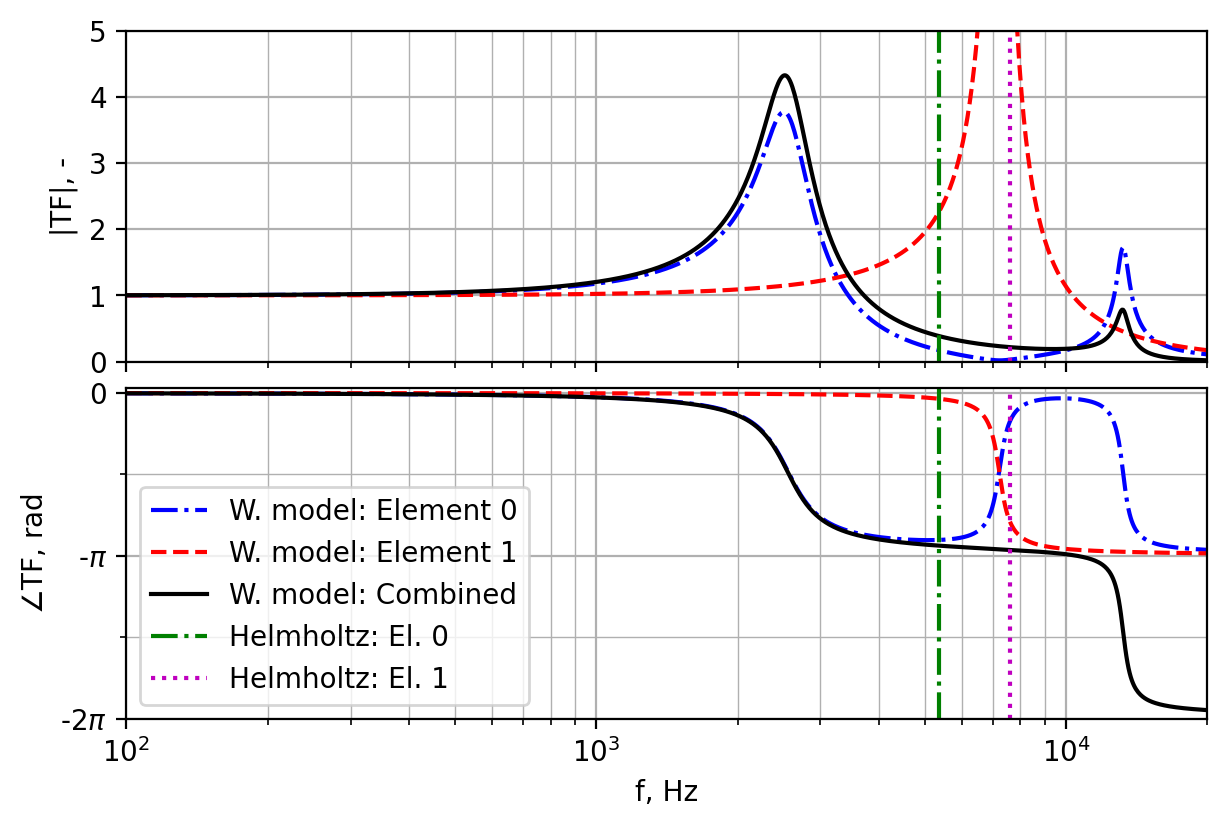

In [31]:
# Visualise all the TFs.
df_pr_serial_all = pd.DataFrame(np.vstack((pr_el_0, pr_el_1, pr_combined)).T,
                         columns=['Element 0', 'Element 1', 'Combined'], index=f_arr)
df_pr_serial_all.index.name = 'f, Hz'
fig_serial_all, ax_serial_all = plot_transfer_function_df(
    df=df_pr_serial_all, fig_dim=(6, 4), x_lim=(F_MIN, F_MAX), y_lim_amp=(0, 5), y_lim_phase=(-2*np.pi, 0.1),
    color=('b', 'r', 'k'), linestyle=('-.', '--', '-'), minor_phase=0.5, prefix='W. model: ')
[ax_s_all_i.axvline(f_r_cavity_el_0, color='g', linestyle='-.', label='Helmholtz: El. 0')
 for ax_s_all_i in ax_serial_all];
[ax_s_all_i.axvline(f_r_cavity_el_1, color='m', linestyle=':', label='Helmholtz: El. 1')
 for ax_s_all_i in ax_serial_all];
ax_serial_all[1].legend(loc='lower left')
fig_serial_all.tight_layout(pad=0.1)

Firstly, the TF of element 1 is simply that of a separate tube-transducer element. The impact of the elements it is connected to, i.e., the upstream elements, does not impact the TF of the element. Only downstream elements impact the TF of a tube-transducer element, such as for element 0, where the resonance of element 1 shows up in the TF of element 0.

Using the more modular **tt_m.Element** object, any type of geometry can be made. One can achieve a similar TF using this object in the following way:

In [32]:
el0 = tt_m.Element(*norm_param_el_0, gamma=GAMMA, pr=PR)
el1 = tt_m.Element(*norm_param_el_1, gamma=GAMMA, pr=PR)

el0.add_child(child_element=el1, vt_child__vv_elem=vt_el_1__vv_el_0, c_child__c_elem=1.)
# The p_ratio method is the same as calling the object itself, i.e. object.p_ratio(w_array) is the same as object(w_array).
pr_el_0 = el0.p_ratio(w=w_arr)
pr_el_1 = el1(w=w_arr)

## Remote microphone probe (RMP)

The reason for choosing the Whitmore model over the Bergh & Tijdeman model is because it allows for branching geometries, as mentioned before.

The example RMP presented here is a sort of *semi-infinite waveguide* type. A long tube is connected to the inlet of the probe. In a thinner side-branch of this tube, a microphone is positioned. The main tube should be long enough such that any pressure wave that enters the probe at the inlet is measured by the side-branch, but partly continues along the main tube. The main tube is long enough that any pressure wave that makes it to the end and reflects back is attenuated before it reaches the side-branch mounted microphone.

In [33]:
# Dimensional parameters of all the elements.
#   - Upper: From inlet of RMP to junction to which side-branch is connected.
LRV_ELEMENT_UPPER = (10E-3, 0.50E-3, 1E-12)
#   - Side: From cavity of upper element (junction) to side-branch mounted microphone cavity.
LRV_ELEMENT_SIDE = (2E-3, 0.20E-3, 20E-9)
#   - Lower: From cavity of upper element (junction) to the end of a long tube, which serves as an attenuation tube.
LRV_ELEMENT_LOWER = (500E-3, 0.50E-3, 20E-9)

In [34]:
# Normalised geometrical parameters.
#   - The elements themselves.
norm_param_upper = tt_m.dim_to_norm(*LRV_ELEMENT_UPPER, c0=C0, nu=NU, alpha_complex=True)
norm_param_side = tt_m.dim_to_norm(*LRV_ELEMENT_SIDE, c0=C0, nu=NU, alpha_complex=True)
norm_param_lower = tt_m.dim_to_norm(*LRV_ELEMENT_LOWER, c0=C0, nu=NU, alpha_complex=True)
#   - The connection between elements.
vt_side__vv_upper = LRV_ELEMENT_SIDE[0] * np.pi*LRV_ELEMENT_SIDE[1]**2 / LRV_ELEMENT_UPPER[2]
vt_lower__vv_upper = LRV_ELEMENT_LOWER[0] * np.pi*LRV_ELEMENT_LOWER[1]**2 / LRV_ELEMENT_UPPER[2]

In this example the **Element** class/object is used. The *tt_m.whitmore_junction* function could be used as well. The object simply allows for a lot more freedom in defining the probe geometry.
The steps to building any geometry are:
1. Create the separate tube-transducer elements objects using the *Element* class.
2. Link these elements together using the *add_child* child method of the *Element* object.
3. Compute the TF of each element that is required to construct the desired full TF (e.g. from the inlet of upper to the cavity of side requires the TF of both of these elements, but not that of the lower element).
4. Combine the TF of the elements together.

In [35]:
# 1. Build elements.
el_upper = tt_m.Element(*norm_param_upper, gamma=GAMMA, pr=PR)
el_side = tt_m.Element(*norm_param_side, gamma=GAMMA, pr=PR)
el_lower = tt_m.Element(*norm_param_lower, gamma=GAMMA, pr=PR)
# 2. Combine the elements.
el_upper.add_child(child_element=el_side, vt_child__vv_elem=vt_side__vv_upper, c_child__c_elem=1.)
el_upper.add_child(child_element=el_lower, vt_child__vv_elem=vt_lower__vv_upper, c_child__c_elem=1.)
# 3. Compute the element TFs.
pr_upper = el_upper(w=w_arr)
pr_side = el_side(w=w_arr)
pr_lower = el_lower(w=w_arr)
# 4. Combine the element TFs.
pr_upper_and_side = pr_upper * pr_side

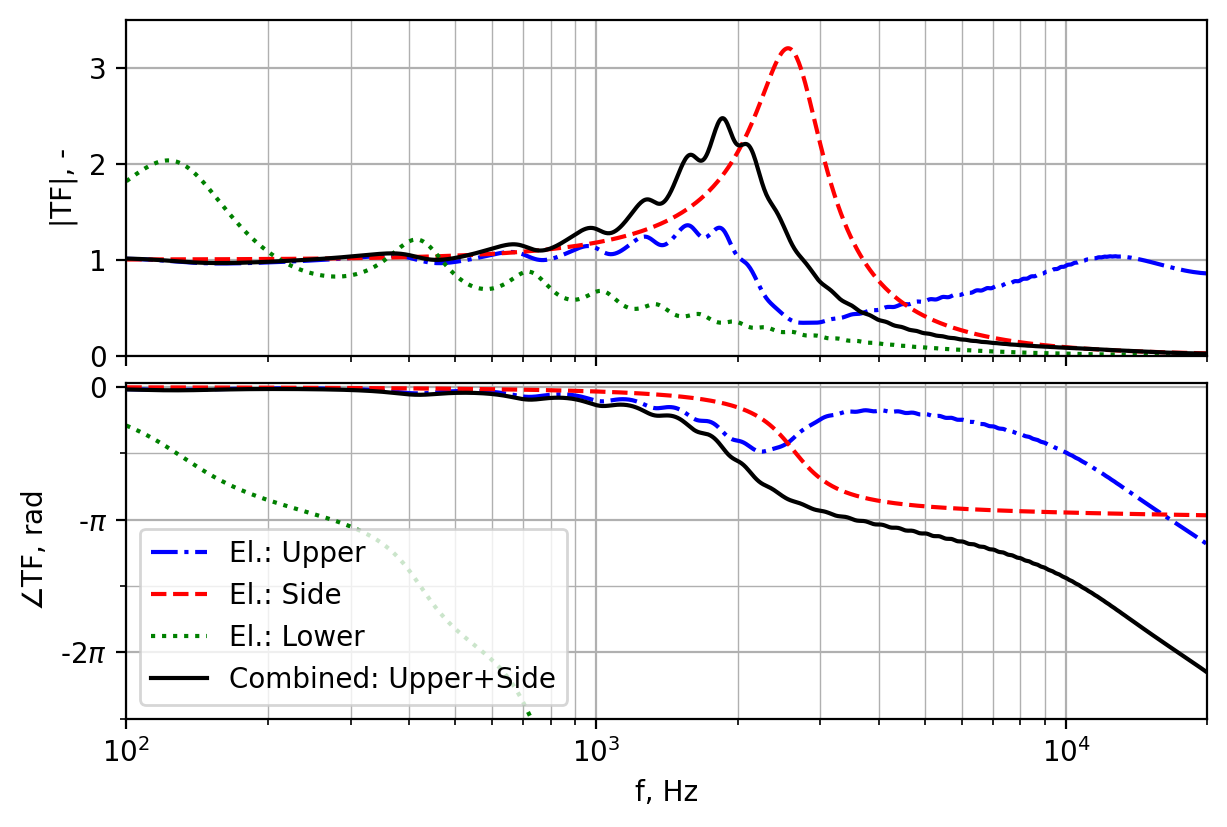

In [36]:
# Visualisation.
df_pr_rmp_all = pd.DataFrame(
    np.vstack((pr_upper, pr_side, pr_lower, pr_upper_and_side)).T, index=f_arr,
    columns=['El.: Upper', 'El.: Side', 'El.: Lower', 'Combined: Upper+Side'])
df_pr_rmp_all.index.name = 'f, Hz'
fig_rmp, ax_rmp = plot_transfer_function_df(
    df=df_pr_rmp_all, fig_dim=(6, 4), x_lim=(F_MIN, F_MAX), y_lim_amp=(0, 3.5), y_lim_phase=(-2.5*np.pi, 0.1),
    color=('b', 'r', 'g', 'k'), linestyle=('-.', '--', ':', '-'), minor_phase=0.5)
ax_rmp[1].legend(loc='lower left')
fig_rmp.tight_layout(pad=0.1)

In this case it can be seen that a lot of *wiggles* exist in the low frequencies. Low-frequency resonance is less affected by viscous attenuation from the capillary tubes. As such, to attenuate any reflections from the end of the lower tube back to the side-branch tube, a longer attenuation/lower tube is required.

The advantage of a *semi-infinite waveguide* probe is that it achieves a similar TF as the side-branch element separately (which itself is like a short pinhole probe), but with a lower resonant amplification peak, and with the microphone mounted further from the inlet (which allows one more freedom in designing the mounting of the probe or the placement of the probe in a tight geometry).

Feel free to play with the length of the lower/attenuation tube. Do note that the main tube (upper and lower tubes) should have a constant radius, to not cause any reflections.

## Analytical v. Empirical calibration

At this point, one could wonder why empirical calibration is the norm, when these models provide theoretically perfect TF of the probe.

It is infeasible in almost all situations to measure the geometrical (and atmospheric) parameters that affect the TF accurately. Any error in the estimation of the parameters result in a direct error in the TF estimate. Correcting the unsteady pressure measurements with a TF with all the resonant frequencies shifted by a bit, results in an error where the resonant peak should actually be, and where it is erroneously corrected for with the TF estimate. On the other hand, empirical calibration directly measures the response of the probe, and therefore requires little to no knowledge regarding the probe geometry or atmospheric conditions. It does however represent a 'snapshot' of the frequency response of the probe at the specific atmospheric conditions present during calibration. Any changes in temperature, pressure, or 'flow velocity over the inlet port' will impact the actual TF of the probe during the unsteady pressure measurements.

This is where the proposed semi-empirical calibration method comes in. By fitting the analytical TF model onto empirical calibration data, the TF ought to be theoretically sound (for the considered geometry, so no spurious resonance), and no exact knowledge regarding the parameter values are needed (as they are inferred from the fit with the data).